In [2]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV


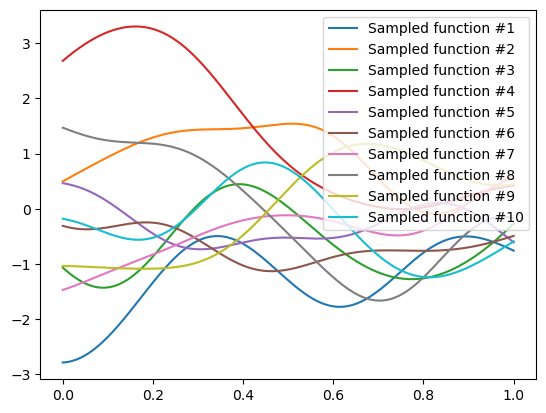

In [3]:
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1,10.0))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=2)

N = 31 * 29 + 1
t = np.linspace(0,1,N)
dt = t[1]-t[0]

X = t.reshape(-1, 1)
n_samples=10

y_samples = gpr.sample_y(X, n_samples)

plt.figure()
for idx, single_prior in enumerate(y_samples.T):
    plt.plot(
        t,
        single_prior,
        label=f"Sampled function #{idx + 1}",
    )

plt.legend()

forcing_terms = y_samples.T

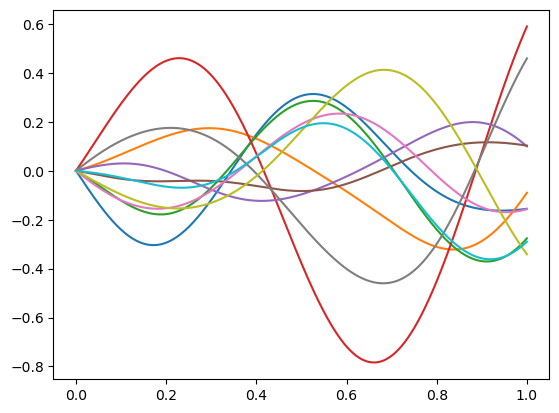

In [4]:
def f(t,u, force):
    k = 9.81/0.2
    u0 = u[1]
    u1 = -k*np.sin(u[0]) + force[int(t/dt)]
    U = np.array([u0, u1])
    return U

plt.figure()
solutions = []
for ft in forcing_terms:
    sol = scipy.integrate.solve_ivp(lambda t, y: f(t,y,ft), y0=[0,0], t_span=[0,1],t_eval=t)
    solutions.append(sol)
    plt.plot(sol.t, sol.y[1])


In [18]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

def Kt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = - (1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T)
    return coeff * K(X, Y)

def Ktt(X, Y, col, K):
    l = K.get_params()['length_scale']
    coeff = (1/l**2) * ((1/l**2) * (X[:,col:col+1] - Y[:, col:col+1].T) ** 2 -1)
    return coeff * K(X,Y)


class KernelModel(BaseEstimator, RegressorMixin):
    def __init__(self, nugget=1e-7, length_scale=1, partial_derivative_order=0, partial_derivative_column=0):
        self.length_scale = length_scale
        self.nugget = nugget
        self.partial_derivative_order = partial_derivative_order
        self.partial_derivative_column = partial_derivative_column
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.K = RBF(length_scale=self.length_scale)
        UXX = self.K(self.X_, self.X_)
        UXX_nugget = (UXX + self.nugget ** 2 * np.eye(self.X_.shape[0]))
        self.UXX_inv_y = np.linalg.solve(UXX_nugget, self.y_)
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        if(self.partial_derivative_order == 0):
            UxX = self.K(X, self.X_)
            return UxX @ self.UXX_inv_y
        elif(self.partial_derivative_order == 1):
            UxX = Kt(X, self.X_, self.partial_derivative_column, self.K)
            return UxX @ self.UXX_inv_y
        elif(self.partial_derivative_order == 2):
            UxX = Ktt(X, self.X_, self.partial_derivative_column, self.K)
            return UxX @ self.UXX_inv_y
    
    def set_params(self, **params):
        if not params:
            return self

        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)

        return self


In [49]:
ut = solutions[2].y[1]
u = solutions[2].y[0]
u_std = np.std(u)
noise = np.random.normal(0,0.1*u_std,N)
u_perturbed = u + noise
u_t_perturbed = ut + noise

scaler = StandardScaler()

t_sample = t[::31]
T_sample = t_sample.reshape(-1,1)
u_sample = u_perturbed[::31]
u_t_sample = u_t_perturbed[::31]

Best parameters found:  {'length_scale': 0.8}
Best estimator:  KernelModel(length_scale=0.8, nugget=5e-08)
Best cross-validation score:  -3.0942024098272472e-06


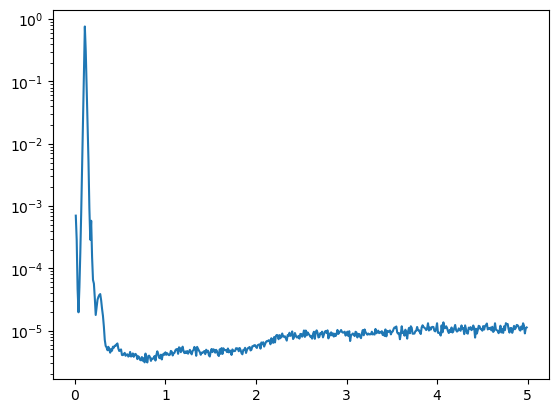

In [50]:
l_range = np.arange(0.01,5, 0.01)
cv = ShuffleSplit(n_splits=10, random_state=0)
grid_search = GridSearchCV(estimator=KernelModel(5e-8, 1), param_grid={'length_scale': l_range}, cv=cv, scoring='neg_mean_squared_error')

# Fit the GridSearchCV
grid_search.fit(T_sample, u_sample)

# Extract the best parameters and model
print("Best parameters found: ", grid_search.best_params_)
print("Best estimator: ", grid_search.best_estimator_)
print("Best cross-validation score: ", grid_search.best_score_)

results = grid_search.cv_results_
df = pd.DataFrame(results)
plt.figure()
plt.semilogy(l_range, -df['mean_test_score'])

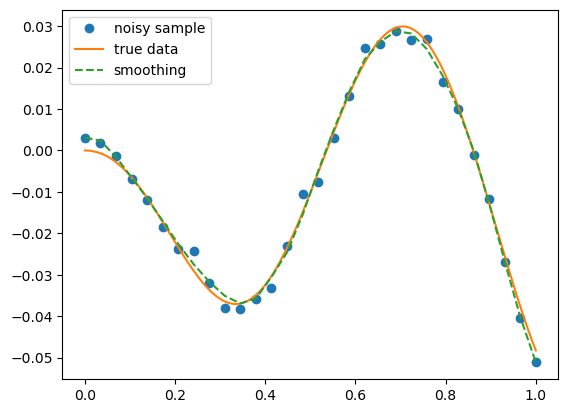

In [52]:
l = 0.8
eta = 5e-8
T = t.reshape(-1,1)
km = KernelModel(eta, l)
u_star = km.fit(T_sample, u_sample).predict(T_sample)

plt.figure()
plt.plot(t_sample, u_sample, 'o', label='noisy sample')
plt.plot(T, u, label='true data')
plt.plot(T_sample, u_star, '--', label='smoothing')
plt.legend()

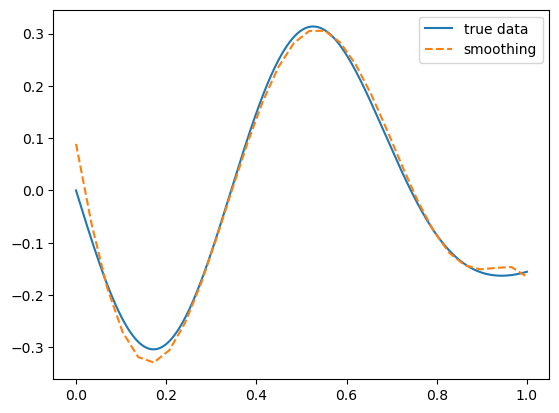

In [20]:
u_t_star = KernelModel(eta, l, 1, 0).fit(T_sample, u_sample).predict(T_sample)

plt.figure()
# plt.plot(t_sample, u_sample, 'o', label='noisy sample')
plt.plot(T, ut, label='true data')
plt.plot(T_sample, u_t_star, '--', label='smoothing')
plt.legend()

In [78]:
training_data = []
for sol in solutions:
    u = sol.y[0]
    u_std = np.std(u)
    noise = np.random.normal(0,0.05*u_std, N)
    u_perturbed = u + noise

    t_sample = t[::31].reshape(-1,1)
    u_sample = u_perturbed[::31]
    u_true = u[::31]
    training_data.append(np.column_stack((T_sample, u_sample, u_true)))

In [86]:
S_array = []
best_params = []
cv_results = []
l_range = np.arange(0.01, 5, 0.01)
eta = 5e-8

for data in training_data:

    u_sample = data[:,1]
    t_sample = data[:,0]

    cv = ShuffleSplit(n_splits=10, random_state=0)
    grid_search = GridSearchCV(estimator=KernelModel(eta, 1), 
                               param_grid={'length_scale': l_range}, 
                               cv=cv, 
                               scoring='neg_mean_squared_error')

    # Fit the GridSearchCV
    grid_search.fit(t_sample, u_sample)
    km = grid_search.best_estimator_
    s0 = t_sample
    s1 = km.predict(t_sample)
    s2 = km.set_params(partial_derivative_order=1).predict(T_sample)
    s3 = km.set_params(partial_derivative_order=2).predict(T_sample)
    Si = np.column_stack((s0,s1,s2,s3))
    S_array.append(Si)
    best_params.append(grid_search.best_params_)
    cv_results.append(grid_search.cv_results_)


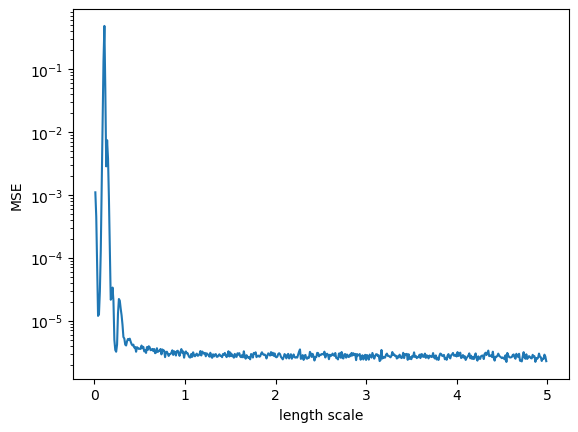

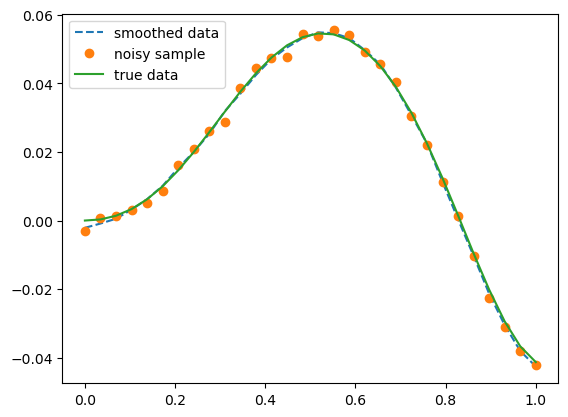

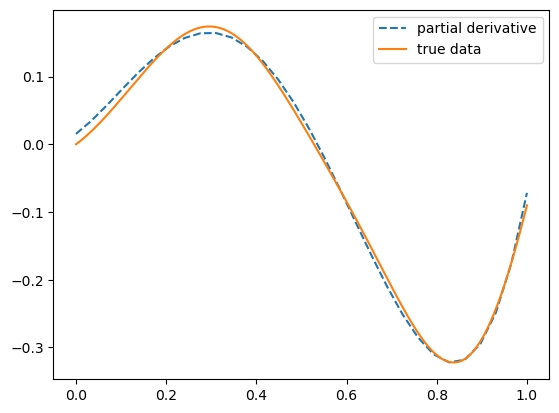

In [91]:
S = np.vstack(S_array)
i = 1
S1 = S[30*i:30*(i+1),:]

df = pd.DataFrame(cv_results[i])
plt.figure()
plt.semilogy(l_range, -df['mean_test_score'])
plt.xlabel('length scale')
plt.ylabel('MSE')

plt.figure()
plt.plot(S1[:,0], S1[:,1],'--', label='smoothed data')
plt.plot(t_sample, training_data[i][:,1],'o', label='noisy sample')
plt.plot(t_sample, training_data[i][:,2], label='true data')
plt.legend()

plt.figure()
plt.plot(S1[:,0], S1[:,2],'--', label='partial derivative')
plt.plot(t, solutions[i].y[1], label='true data')
plt.legend()

In [81]:
best_params

[{'length_scale': 0.71},
 {'length_scale': 4.55},
 {'length_scale': 1.32},
 {'length_scale': 2.94},
 {'length_scale': 4.28},
 {'length_scale': 1.26},
 {'length_scale': 2.49},
 {'length_scale': 1.99},
 {'length_scale': 1.55},
 {'length_scale': 1.1400000000000001}]

{'mean_fit_time': array([6.94036484e-05, 6.71148300e-05, 6.72578812e-05, 7.05003738e-05,
        7.17639923e-05, 6.27756119e-05, 6.32047653e-05, 6.59227371e-05,
        6.78300858e-05, 6.78300858e-05, 7.04050064e-05, 6.95466995e-05,
        6.70194626e-05, 6.75439835e-05, 6.76393509e-05, 6.67810440e-05,
        6.78539276e-05, 6.69479370e-05, 7.08103180e-05, 8.08477402e-05,
        6.50882721e-05, 6.41584396e-05, 6.40392303e-05, 6.42061234e-05,
        6.55651093e-05, 6.84976578e-05, 7.08818436e-05, 6.83307648e-05,
        6.48021698e-05, 6.30378723e-05, 6.27279282e-05, 6.50882721e-05,
        6.68048859e-05, 6.67810440e-05, 6.94036484e-05, 7.89403915e-05,
        6.34193420e-05, 6.33955002e-05, 6.78777695e-05, 6.72817230e-05,
        6.72817230e-05, 6.73532486e-05, 6.89268112e-05, 6.72817230e-05,
        6.73770905e-05, 6.68764114e-05, 6.74009323e-05, 6.75916672e-05,
        6.68525696e-05, 6.68048859e-05, 6.86883926e-05, 6.82830811e-05,
        6.75678253e-05, 6.69717789e-05, 6.69956